This is a ResUNET segmentation model, based on implementation in 'Segmentation Gym'

https://github.com/Doodleverse/segmentation_gym


In [1]:
# import the packages we need...
#first, the general stuff
import os
from os import getcwd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd


#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.3.2


In [2]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [3]:
#define the number of classes of the image...these are NOAA, so 

num_classes = 4

#this is a fn to make sure the doodler-derived labels go from 0- (num_classes-1)

def D_Filter(image):
    image[image>(num_classes-1)] = (num_classes-1)
    return image

In [4]:
#build data flow routines, gettign the data from the files to the netowrk...

#first we decide how much of the data is training and how much is validation
split = 0.4

# Define dirs and files where the images and labels are.. Use doodler to get labels for your images!
image_dir = '../data/segmentation/images'
label_dir = '../data/segmentation/labels'

#to make it deterministic, set the seed
SEED = 11

# We will use generators to flow the data.. for both training and validaton
# We also add some weak data-augmentation, and rescale the images here.
# note that we are using the generator to split the data. 

#Segmentation gym uses a different normalization tehcnique, not rescaling..
#instead it uses something akin to (samplewise_center + samplewise_std_normalization)

#train generators
train_image_datagen = ImageDataGenerator(rescale =1./255.,
                                   rotation_range = 5,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   zoom_range = 0.1,
                                   fill_mode='reflect',
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)

train_mask_datagen = ImageDataGenerator(
                                   rotation_range = 5,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   zoom_range = 0.1,
                                   fill_mode='reflect',
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   preprocessing_function = D_Filter,
                                   validation_split = split )
#val generators with no aug
# https://stackoverflow.com/questions/61864244/how-to-avoid-augmenting-data-in-validation-split-of-keras-imagedatagenerator)
val_image_datagen = ImageDataGenerator(rescale =1./255.,
                                   validation_split = split)

val_mask_datagen = ImageDataGenerator(preprocessing_function = D_Filter,
                                   validation_split = split )

#set batch Size for the model — how many images go into the network at each
#step. 
batch_size = 14

#set Image size. We are using a UNET based on Segmentation Zoo.. 
# size choices are:
#
#(RGB so imshape is 3)
pix_dim_x = 768
pix_dim_y = 1024
imsize = (pix_dim_x,pix_dim_y) 
imshape = (pix_dim_x,pix_dim_y,3)

masksize = (pix_dim_x,pix_dim_y) 


### This is where we set the generator to flow images from the folders into the 
#training. The is a generator for the image and another for the mask. And also 
# generators for the traing and val.. so 4 total.:

train_image_generator = train_image_datagen.flow_from_directory(image_dir,
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = imsize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    interpolation = "nearest",
                                                    subset ='training')

train_label_generator = train_mask_datagen.flow_from_directory(label_dir,
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = masksize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    color_mode = "grayscale",
                                                    interpolation = "nearest",
                                                    subset = 'training')

# we merge the two training generators (image and mask) so that it looks like a
# a single generator 
train_generator = zip(train_image_generator, train_label_generator)



# Flow validation images in batches 


val_image_generator = val_image_datagen.flow_from_directory(image_dir, # same directory as training data
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = imsize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    interpolation = "nearest",
                                                    subset = 'validation')

val_label_generator = val_mask_datagen.flow_from_directory(label_dir, # same directory as training data
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = masksize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    color_mode = "grayscale",
                                                    interpolation = "nearest",
                                                    subset = 'validation')

#merge generators
validation_generator = zip(val_image_generator, val_label_generator)


Found 358 images belonging to 1 classes.
Found 358 images belonging to 1 classes.
Found 238 images belonging to 1 classes.
Found 238 images belonging to 1 classes.


In [5]:
#Set total number of images in each subset, which is the output from the above cell.
# this will be used later when we train the model
total_train = 358
total_val = 238

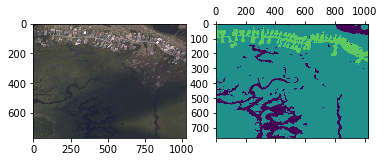

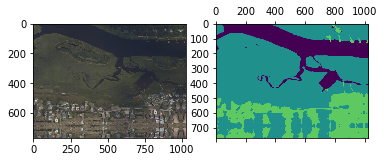

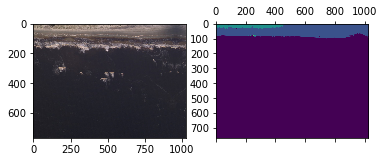

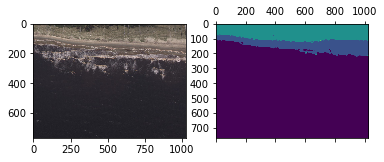

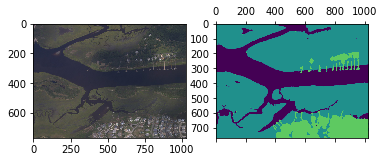

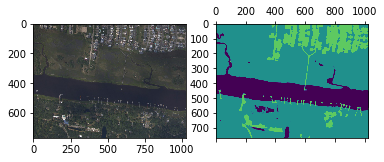

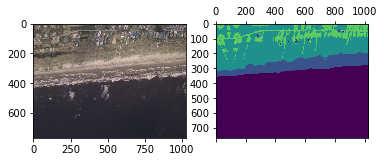

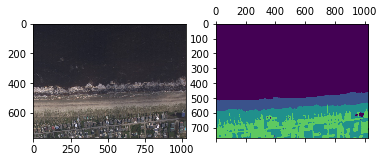

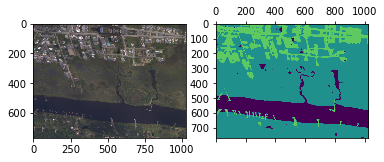

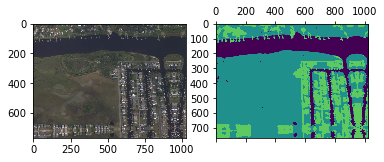

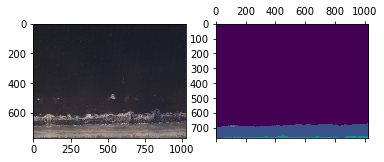

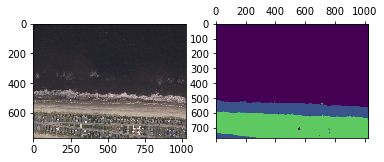

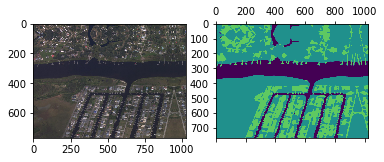

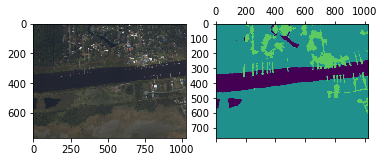

In [6]:
#as an idiot check, lets look at the output of the generator.
#for a full training batch... 

x,y = next(train_generator)

for count,(im,lab) in enumerate(zip(x, y)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(im)
    ax2.matshow(lab.squeeze(), vmin = 0, vmax = 4)


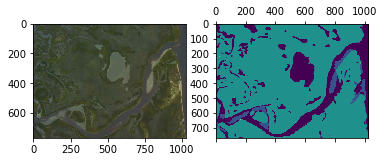

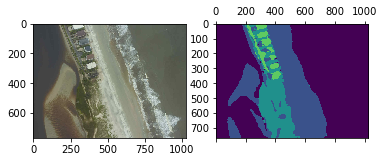

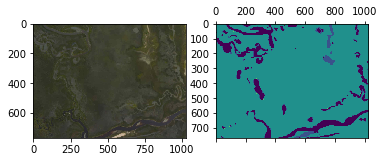

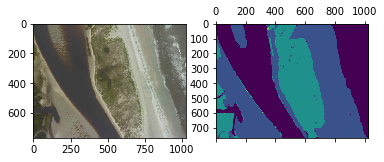

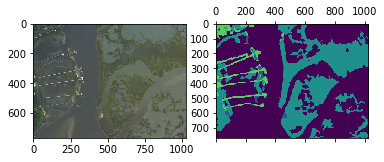

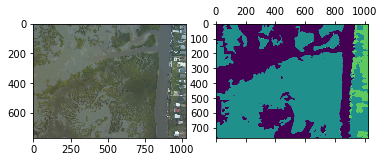

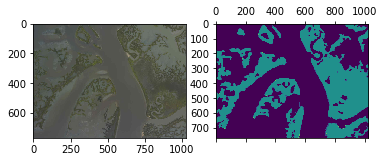

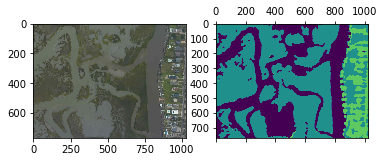

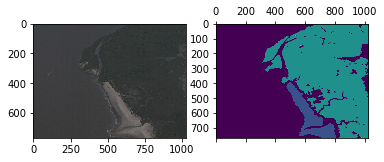

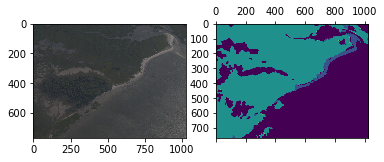

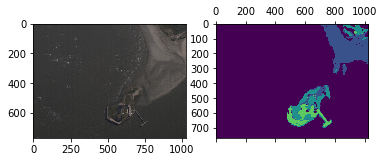

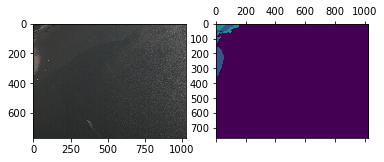

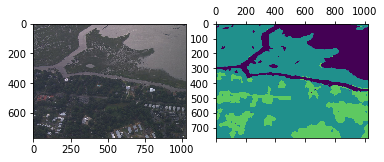

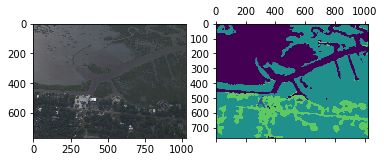

In [7]:
#as an idiot check, lets look at the output of the generator.
#for a full training batch... 

x,y = next(validation_generator)

for count,(im,lab) in enumerate(zip(x, y)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(im)
    ax2.matshow(lab.squeeze(), vmin = 0, vmax = 4)


In [8]:
#define the model building functions

#-----------------------------------
def upsamp_concat_block(x, xskip):
    """
    upsamp_concat_block(x, xskip)
    This function takes an input layer and creates a concatenation of an upsampled version and a residual or 'skip' connection
    INPUTS:
        * `xskip`: input keras layer (skip connection)
        * `x`: input keras layer
    OPTIONAL INPUTS: None
    GLOBAL INPUTS: None
    OUTPUTS:
        * keras layer, output of the addition between residual convolutional and bottleneck layers
    """
    u = tf.keras.layers.UpSampling2D((2, 2))(x)

    return tf.keras.layers.Concatenate()([u, xskip])


#-----------------------------------
def conv_block(x, filters, kernel_size = (7,7), padding="same", strides=1, dropout=0.1):
    """
    conv_block(x, filters, kernel_size = (7,7), padding="same", strides=1)
    This function applies batch normalization to an input layer, then convolves with a 2D convol layer
    The two actions combined is called a convolutional block
    INPUTS:
        * `filters`: number of filters in the convolutional block
        * `x`:input keras layer to be convolved by the block
    OPTIONAL INPUTS:
        * `kernel_size`=(3, 3): tuple of kernel size (x, y) - this is the size in pixels of the kernel to be convolved with the image
        * `padding`="same":  see tf.keras.layers.Conv2D
        * `strides`=1: see tf.keras.layers.Conv2D
    GLOBAL INPUTS: None
    OUTPUTS:
        * keras layer, output of the batch normalized convolution
    """

    # dropout_type =  "standard"
    # dropout=0.1


    DO = tf.keras.layers.Dropout

    if dropout > 0.0:
        x = DO(dropout)(x)

    conv = batchnorm_act(x)
    return tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)

#-----------------------------------
def bottleneck_block(x, filters, kernel_size = (2,2), padding="same", strides=1):
    """
    bottleneck_block(x, filters, kernel_size = (7,7), padding="same", strides=1)
    This function creates a bottleneck block layer, which is the addition of a convolution block and a batch normalized/activated block
    INPUTS:
        * `filters`: number of filters in the convolutional block
        * `x`: input keras layer
    OPTIONAL INPUTS:
        * `kernel_size`=(3, 3): tuple of kernel size (x, y) - this is the size in pixels of the kernel to be convolved with the image
        * `padding`="same":  see tf.keras.layers.Conv2D
        * `strides`=1: see tf.keras.layers.Conv2D
    GLOBAL INPUTS: None
    OUTPUTS:
        * keras layer, output of the addition between convolutional and bottleneck layers
    """
    conv = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides, dropout=0.0)

    bottleneck = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)

    return tf.keras.layers.Add()([conv, bottleneck])

#-----------------------------------
def res_block(x, filters, kernel_size = (7,7), padding="same", strides=1, dropout=0.1):
    """
    res_block(x, filters, kernel_size = (7,7), padding="same", strides=1)
    This function creates a residual block layer, which is the addition of a residual convolution block and a batch normalized/activated block
    INPUTS:
        * `filters`: number of filters in the convolutional block
        * `x`: input keras layer
    OPTIONAL INPUTS:
        * `kernel_size`=(3, 3): tuple of kernel size (x, y) - this is the size in pixels of the kernel to be convolved with the image
        * `padding`="same":  see tf.keras.layers.Conv2D
        * `strides`=1: see tf.keras.layers.Conv2D
    GLOBAL INPUTS: None
    OUTPUTS:
        * keras layer, output of the addition between residual convolutional and bottleneck layers
    """
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides, dropout=dropout)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1, dropout=dropout)

    bottleneck = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)

    return tf.keras.layers.Add()([bottleneck, res])
#-----------------------------------
def batchnorm_act(x):
    """
    batchnorm_act(x)
    This function applies batch normalization to a keras model layer, `x`, then a relu activation function
    INPUTS:
        * `z` : keras model layer (should be the output of a convolution or an input layer)
    OPTIONAL INPUTS: None
    GLOBAL INPUTS: None
    OUTPUTS:
        * batch normalized and relu-activated `x`
    """
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.layers.Activation("relu")(x)

#-----------------------------------
#-----------------------------------

#Define the Resunet model building function
def custom_resunet(sz,
    f,
    nclasses=1,
    kernel_size=(7,7),
    strides=2,
    dropout=0.1,
    dropout_change_per_layer=0.0,
    dropout_type="standard",
    use_dropout_on_upsampling=False,
    ):
    """
    res_unet(sz, f, nclasses=1)
    This function creates a custom residual U-Net model for image segmentation
    INPUTS:
        * `sz`: [tuple] size of input image
        * `f`: [int] number of filters in the convolutional block
        * flag: [string] if 'binary', the model will expect 2D masks and uses sigmoid. If 'multiclass', the model will expect 3D masks and uses softmax
        * nclasses [int]: number of classes
        dropout (float , 0. and 1.): dropout after the first convolutional block. 0. = no dropout
        dropout_change_per_layer (float , 0. and 1.): Factor to add to the Dropout after each convolutional block
        dropout_type (one of "spatial" or "standard"): Spatial is recommended  by  https://arxiv.org/pdf/1411.4280.pdf
        use_dropout_on_upsampling (bool): Whether to use dropout in the decoder part of the network
        filters (int): Convolutional filters in the initial convolutional block. Will be doubled every block
    OPTIONAL INPUTS:
        * `kernel_size`=(7, 7): tuple of kernel size (x, y) - this is the size in pixels of the kernel to be convolved with the image
        * `padding`="same":  see tf.keras.layers.Conv2D
        * `strides`=1: see tf.keras.layers.Conv2D
    GLOBAL INPUTS: None
    OUTPUTS:
        * keras model
    """
    inputs = tf.keras.layers.Input(sz)

    ## downsample
    e1 = bottleneck_block(inputs, f)
    f = int(f*2)
    e2 = res_block(e1, f, strides=strides,  kernel_size = kernel_size, dropout=dropout)
    f = int(f*2)
    dropout += dropout_change_per_layer
    e3 = res_block(e2, f, strides=strides,  kernel_size = kernel_size, dropout=dropout)
    f = int(f*2)
    dropout += dropout_change_per_layer
    e4 = res_block(e3, f, strides=strides,  kernel_size = kernel_size, dropout=dropout)
    f = int(f*2)
    dropout += dropout_change_per_layer
    _ = res_block(e4, f, strides=strides, kernel_size = kernel_size, dropout=dropout)

    ## bottleneck
    b0 = conv_block(_, f, strides=1,  kernel_size = kernel_size,dropout=dropout)
    _ = conv_block(b0, f, strides=1,  kernel_size = kernel_size, dropout=dropout)


    dropout = 0.0
    dropout_change_per_layer = 0.0

    ## upsample
    _ = upsamp_concat_block(_, e4)
    _ = res_block(_, f, kernel_size = kernel_size, dropout=dropout)
    f = int(f/2)
    dropout -= dropout_change_per_layer

    _ = upsamp_concat_block(_, e3)
    _ = res_block(_, f, kernel_size = kernel_size, dropout=dropout)
    f = int(f/2)
    dropout -= dropout_change_per_layer

    _ = upsamp_concat_block(_, e2)
    _ = res_block(_, f, kernel_size = kernel_size, dropout=dropout)
    f = int(f/2)
    dropout -= dropout_change_per_layer

    _ = upsamp_concat_block(_, e1)
    _ = res_block(_, f, kernel_size = kernel_size, dropout=dropout)

    # ## classify
    if nclasses==1:
        outputs = tf.keras.layers.Conv2D(nclasses, (1, 1), padding="same", activation="sigmoid")(_)
    else:
        outputs = tf.keras.layers.Conv2D(nclasses, (1, 1), padding="same", activation="softmax")(_)

    #model creation
    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model


In [9]:
#the model

filters = 7
KERNEL = 9
STRIDE = 2
DROPOUT = 0.1
DROPOUT_CHANGE_PER_LAYER = 0.0

model =  custom_resunet(imshape,
                filters,
                num_classes,
                (KERNEL,KERNEL),
                STRIDE,
                DROPOUT,
                DROPOUT_CHANGE_PER_LAYER
                )
#and print out the text summary of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768, 1024, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 768, 1024, 7) 91          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 768, 1024, 7) 28          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 768, 1024, 7) 28          input_1[0][0]                    
_______________________________________________________________________________________

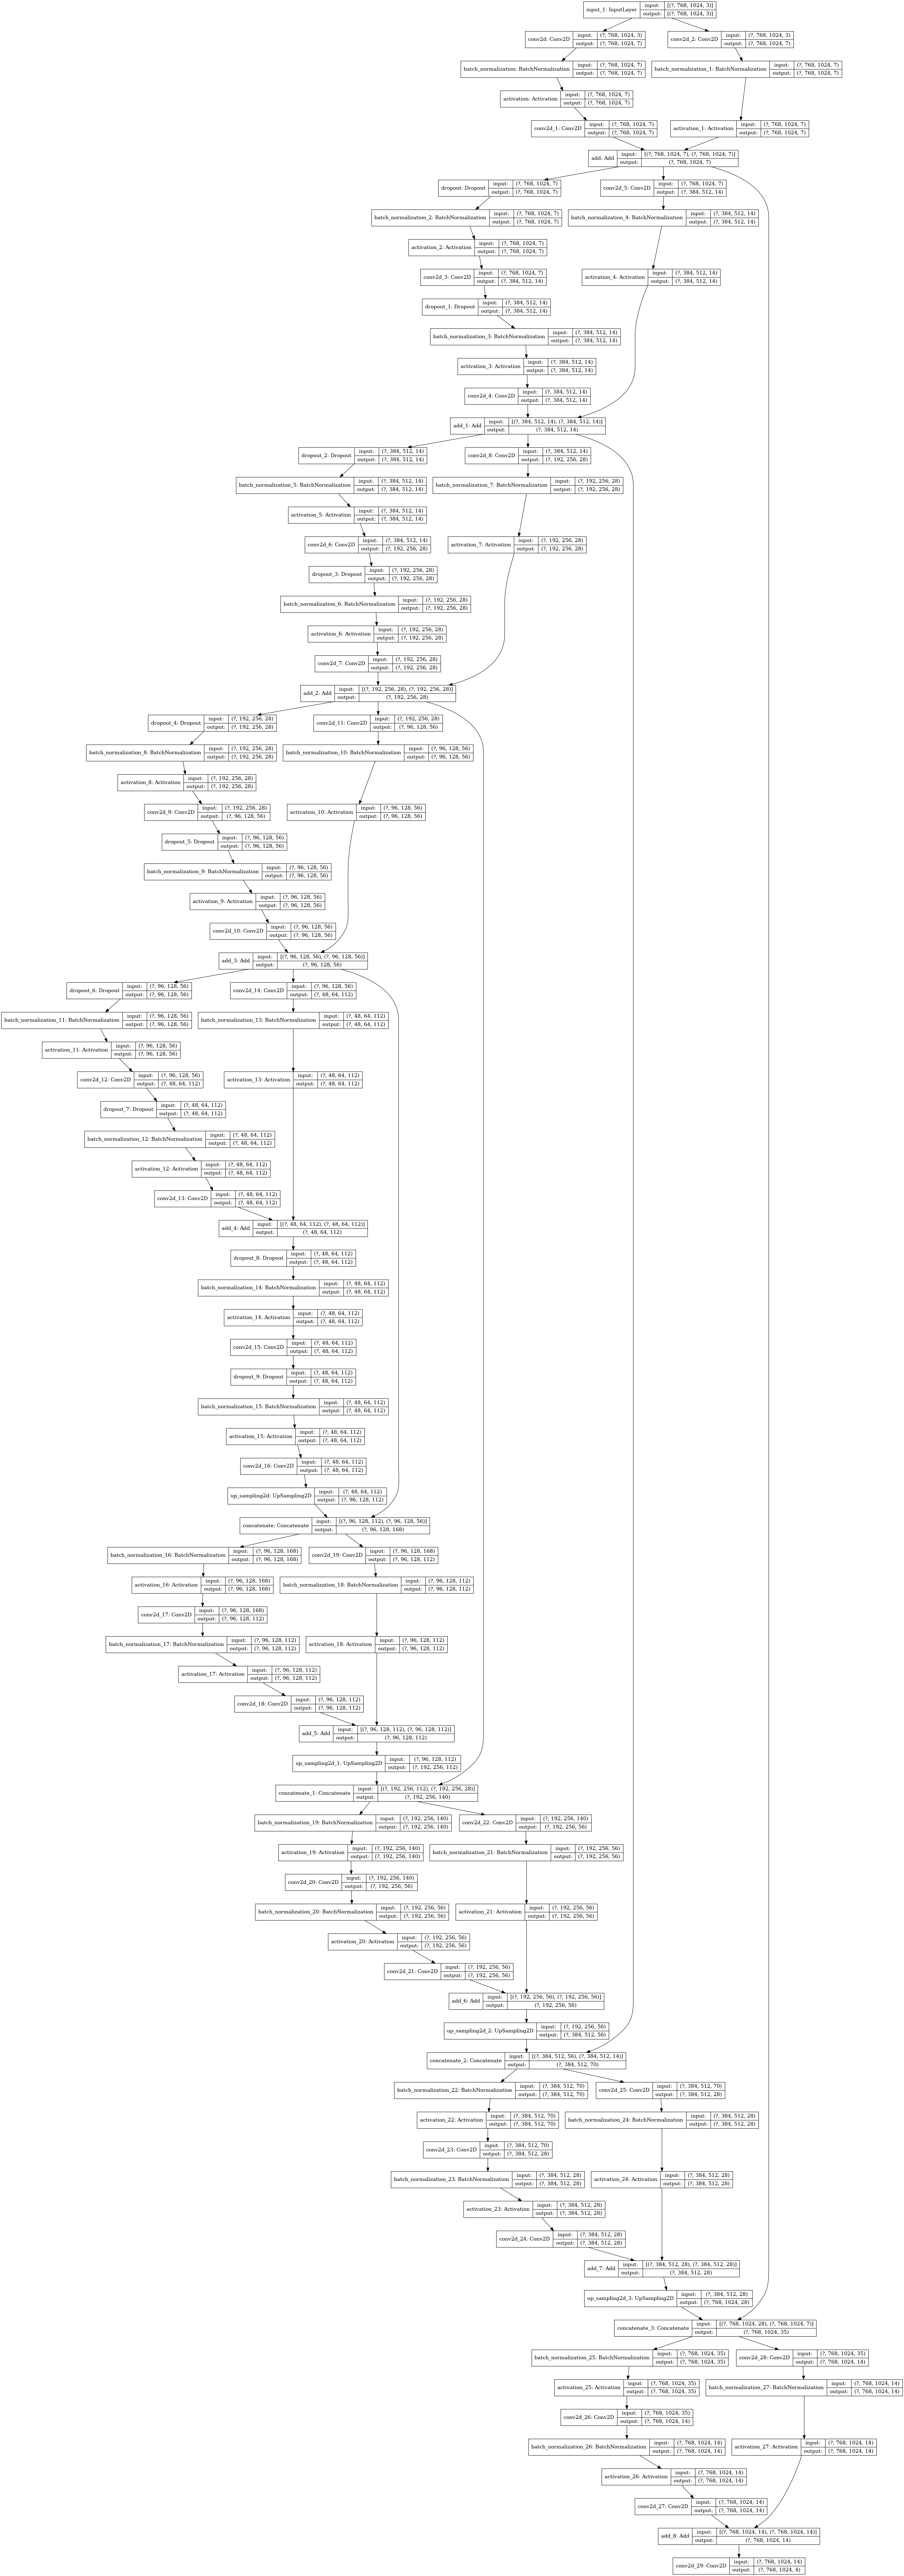

In [10]:
# here is a graphic summary of the model... you can see the downsampling, bottleneck, and upsampling, connected to each other via skip connections
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
#add Gym learning rate scheduler

#     "RAMPUP_EPOCHS": 20,
#     "SUSTAIN_EPOCHS": 5.0,
#     "EXP_DECAY": 0.9,
#     "START_LR":  1e-7,
#     "MIN_LR": 1e-7,
#     "MAX_LR": 1e-4,

In [12]:
#Add gym metricvs like IoU

In [13]:
#we compile the model, set a loss function, and also an optimizer. 

model.compile( loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(0.0001))

In [14]:
# define a callback, which runs during training and does something for us. 
#This one looks at the training loss, and stops the training if the loss does 
#not improve from some number of epochs. Then it reverts to the best version of 
# the model, where loss was lowest

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'loss', 
                                             patience = 20, 
                                             restore_best_weights = True)

In [15]:
#lets now train the model! We can store all teh model output in 'history'.
# note that we are using the training generator for training data, the val 
# generator for validation data, we set the model to train for some number of epochs, 
# we tell teh network how many steps there are to get through the entire data set
# and we also give the network our callback to use.

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs= 100,
                    workers = 24,
                    steps_per_epoch = total_train // batch_size,
                    validation_steps =  total_val // batch_size,
                    callbacks =[callbacks])

Epoch 1/100
25/25 [==============================] - 44s 2s/step - loss: 1.3239 - val_loss: 1.3212
Epoch 2/100
25/25 [==============================] - 40s 2s/step - loss: 1.2853 - val_loss: 1.2480
Epoch 3/100
25/25 [==============================] - 40s 2s/step - loss: 1.2736 - val_loss: 1.2416
Epoch 4/100
25/25 [==============================] - 39s 2s/step - loss: 1.2375 - val_loss: 1.2053
Epoch 5/100
25/25 [==============================] - 39s 2s/step - loss: 1.2113 - val_loss: 1.1813
Epoch 6/100
25/25 [==============================] - 39s 2s/step - loss: 1.2289 - val_loss: 1.2006
Epoch 7/100
25/25 [==============================] - 39s 2s/step - loss: 1.2193 - val_loss: 1.2020
Epoch 8/100
25/25 [==============================] - 39s 2s/step - loss: 1.2340 - val_loss: 1.2150
Epoch 9/100
25/25 [==============================] - 39s 2s/step - loss: 1.1938 - val_loss: 1.2648
Epoch 10/100
25/25 [==============================] - 39s 2s/step - loss: 1.2008 - val_loss: 1.2288
Epoch 11/

25/25 [==============================] - 39s 2s/step - loss: 0.8912 - val_loss: 1.3233
Epoch 84/100
25/25 [==============================] - 39s 2s/step - loss: 0.8997 - val_loss: 1.2226
Epoch 85/100
25/25 [==============================] - 39s 2s/step - loss: 0.8829 - val_loss: 1.4353
Epoch 86/100
25/25 [==============================] - 39s 2s/step - loss: 0.8841 - val_loss: 1.2623
Epoch 87/100
25/25 [==============================] - 39s 2s/step - loss: 0.8790 - val_loss: 1.5715
Epoch 88/100
25/25 [==============================] - 39s 2s/step - loss: 0.8810 - val_loss: 1.3197
Epoch 89/100
25/25 [==============================] - 39s 2s/step - loss: 0.9015 - val_loss: 1.2659
Epoch 90/100
25/25 [==============================] - 39s 2s/step - loss: 0.8831 - val_loss: 1.6040
Epoch 91/100
25/25 [==============================] - 39s 2s/step - loss: 0.8736 - val_loss: 1.1206
Epoch 92/100
25/25 [==============================] - 39s 2s/step - loss: 0.8593 - val_loss: 1.2785
Epoch 93/100


<function matplotlib.pyplot.show(*args, **kw)>

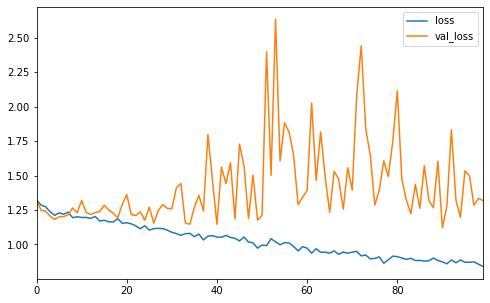

In [16]:
#plot the output
pd.DataFrame(history.history).plot(figsize=(8,5))
#plt.grid(True)
plt.show

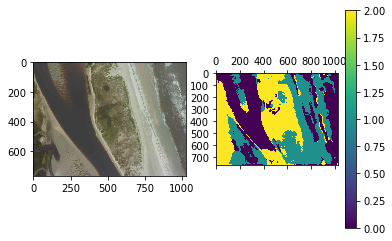

In [20]:
#lets look at the model prediction on a single image.

# here is the gdrive path to the image
imgp = '../data/segmentation/images/images/C26047791-3_EBG.jpg'
#imgp = '../data/segmentation/images/images/C26047791-0_EBG.jpg'

#we pull the image and preprocess it — normalizing and making it a array/tensor
img = tf.keras.preprocessing.image.load_img(imgp,target_size = imsize)
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255
img = np.expand_dims(img,axis=0)

#We use the model to make a prediction on this image
pred = model.predict(img)

# we use argmax to get the labels for the image (recall the output of the 
# model is a tensor with shape of the image and then a depth equal to the 
# number of classes. this argmax and squeeze are here to collapse that).
lab = np.argmax(pred.squeeze(),-1)


#lets look at the model results and the image

imgUP = matplotlib.image.imread(imgp)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img.squeeze())
labels = ax2.matshow(lab)
cax = fig.colorbar(labels, ax = ax2)
plt.show()

# water: 0; sand:1; veg : 2; dev : 3